** Work in Progress -- starting to add commentary and tidy up **


I connected a [BMP180]() temperature and pressure centre to a
raspberry pi and have it running in my study.

I have been using this note book to look at the data as it is generated.

The code uses the Adafruit python library to extract data from the sensor.

I find plotting the data is a good way to take an initial look at it.

So, time for some pandas and matplotlib.

In [267]:
# Tell matplotlib to plot in line
%matplotlib inline

# import pandas
import pandas

# seaborn magically adds a layer of goodness on top of Matplotlib
# mostly this is just changing matplotlib defaults, but it does also
# provide some higher level plotting methods.
import seaborn

# Tell seaborn to set things up
seaborn.set()

In [268]:
# just check where I am
!pwd

/home/jng/devel/peakrisk/posts


In [269]:
infile = '../files/light.csv'

In [275]:
!scp 192.168.0.133:Adafruit_Python_BMP/light.csv .
!mv light.csv ../files

light.csv                                     100%  778KB 777.9KB/s   00:00    


light.csv                                       0%    0     0.0KB/s   --:-- ETA

In [276]:
data = pandas.read_csv(infile, index_col='date', parse_dates=['date'])

In [277]:
data.describe()

               temp       pressure      altitude  sealevel_pressure
count  11659.000000   11659.000000  11659.000000       11659.000000
mean      28.889159  101401.477142    -20.450151      101788.132258
std        4.661283    4885.582477    360.537723        3570.315604
min      -27.100000   28421.000000  -2749.583598       37537.000000
25%       28.000000  101690.000000    -45.938417      101692.000000
50%       28.700000  101785.000000    -38.309883      101787.000000
75%       29.300000  101877.000000    -30.426731      101879.000000
max      162.900000  128808.000000   7610.794710      139326.000000

In [278]:
# Lets look at the temperature data
data.temp.plot()

Looks like we have some bad data here.  For the first few days things look ok though
To start, lets look at the good bit of the data.


In [279]:
data[:4500].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6e9d17f0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6e8a62e8>], dtype=object)

That looks good.  So for the first 4500 samples the data looks clean.

The pressure and sealevel_pressure plots have the same shape.

The sealevel_pressure is just the pressure recording adjusted for altitude.

Actually, since I am not telling the software what my altitude it is

It is a bit of a mystery what is causing the bad data after this.

One possibility is I have a separate process that is talking to the sensor that I am running in a console just so I can see the current figures.

I am running this with a linux *watch* command.   I used the default parameters and it is running every 2 seconds.

I am wondering if the sensor code, or the hardware itself has some bugs if the code polls the sensor whilst it is already being probed.

I am now (11am BDA time July 3rd) running the monitor script with *watch -n 600* so it only polls every 10 minutes.  Will see if that improves things.

So, lets see if we can filter out the bad data

In [219]:
data.temp.plot()

In [220]:
# All the good temperature readings appear to be in the 25C - 32C range,
# so lets filter out the rest.
data.temp[(data.temp < 50.0) & (data.temp > 15.0)].plot()

In [ ]:
That looks good.  You can see 8 days of temperatures rising through the day and then falling at night.  Only a couple of degree difference here in Bermuda at present.

The Third day with the dip in temperature I believe there was a thunderstorm or two which cooled things off temporarily.

I really need to get a humidity sensor working to go with this.

Now lets see if we can spot the outliers and filter them out.

In [222]:
def spot_outliers(series):
    """ Compares the change in value in consecutive samples to the standard deviation

    If the change is bigger than that, assume it is an outlier.

    Note, that there will be two bad deltas, since the sample after the
    bad one will be bad too.
    """
    delta = series - series.shift()

    return delta.abs() > data.std()

outliers = spot_outliers(data)

In [225]:
# Plot temperature
data[~outliers].temp.plot()

In [226]:
data[~outliers].altitude.plot()

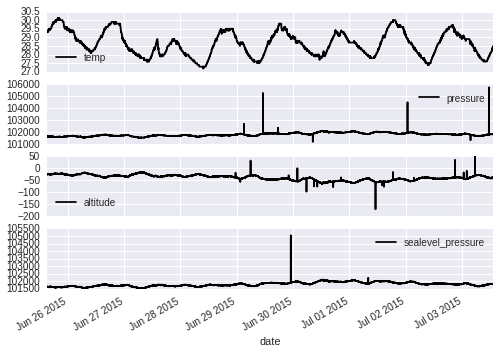

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c72351588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0c721aaef0>], dtype=object)

In [186]:
data[~outliers].plot(subplots=True)

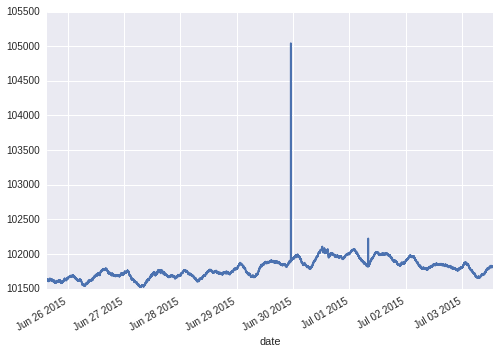

In [187]:
data[~outliers].sealevel_pressure.plot()

In [298]:
def smooth(data, thresh=None):
    
    means = data.mean()

    if thresh is None:
        sds = data.std()
    else:
        sds = thresh
    
    delta = data - data.shift()
    
    good = delta[abs(delta) < sds]

    print(good.describe())
    
    return delta.where(good, 0.0)

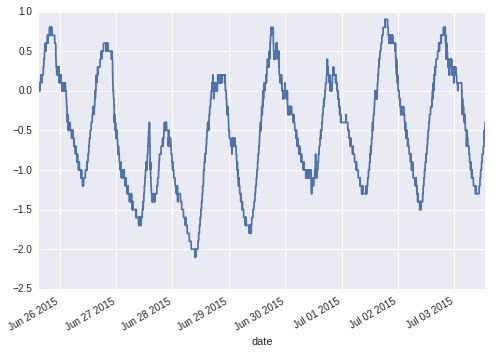

In [189]:
smooth(data).temp.cumsum().plot()

In [292]:
smooth(data).describe() 

               temp      pressure      altitude  sealevel_pressure
count  11659.000000  11659.000000  11659.000000       11659.000000
mean       0.000069      0.012523     -0.001444           0.016554
std        0.033368     77.632060      2.704294          41.958663
min       -0.100000  -3906.000000   -112.489928       -3148.000000
25%        0.000000     -4.000000     -0.331867          -4.000000
50%        0.000000      0.000000      0.000000           0.000000
75%        0.000000      4.000000      0.331749           4.000000
max        0.100000   3906.000000    112.489928        3138.000000

               temp      pressure      altitude  sealevel_pressure
count  11566.000000  11346.000000  11386.000000       11392.000000
mean       0.000069      0.012868     -0.001479           0.016942
std        0.033501     78.695678      2.736525          42.447561
min       -0.100000  -3906.000000   -112.489928       -3148.000000
25%        0.000000     -4.000000     -0.331992          -4.000000
50%        0.000000      0.000000      0.000000           0.000000
75%        0.000000      4.000000      0.331934           4.000000
max        0.100000   3906.000000    112.489928        3138.000000


In [302]:
smooth(data, 5.0).cumsum()[['temp', 'altitude']].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6dc2a898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6dabfc18>], dtype=object)

               temp     pressure      altitude  sealevel_pressure
count  11566.000000  6083.000000  11346.000000        6063.000000
mean       0.000069     0.043893     -0.001571          -0.004948
std        0.033501     2.466790      0.523929           2.466264
min       -0.100000    -4.000000     -2.071579          -4.000000
25%        0.000000    -2.000000     -0.331981          -2.000000
50%        0.000000     0.000000      0.000000           0.000000
75%        0.000000     2.000000      0.331916           2.000000
max        0.100000     4.000000      2.240047           4.000000


In [296]:
data.describe()

               temp       pressure      altitude  sealevel_pressure
count  11659.000000   11659.000000  11659.000000       11659.000000
mean      28.889159  101401.477142    -20.450151      101788.132258
std        4.661283    4885.582477    360.537723        3570.315604
min      -27.100000   28421.000000  -2749.583598       37537.000000
25%       28.000000  101690.000000    -45.938417      101692.000000
50%       28.700000  101785.000000    -38.309883      101787.000000
75%       29.300000  101877.000000    -30.426731      101879.000000
max      162.900000  128808.000000   7610.794710      139326.000000

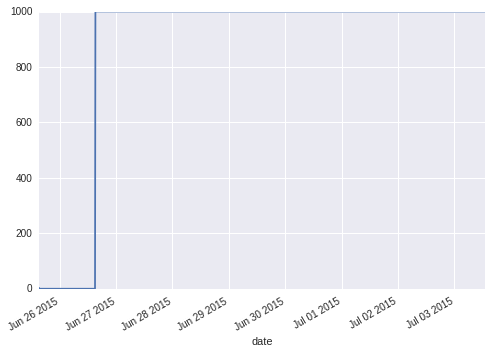

In [191]:
sdata.sealevel_pressure.cumsum().clip(0, 1000).plot()

In [289]:
sdata[['temp', 'altitude']].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6e217c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6e0f7a20>], dtype=object)

In [282]:
smooth(data).cumsum().columns(['temp', 'altitude']).plot(subplots=True)

TypeError: 'Index' object is not callable

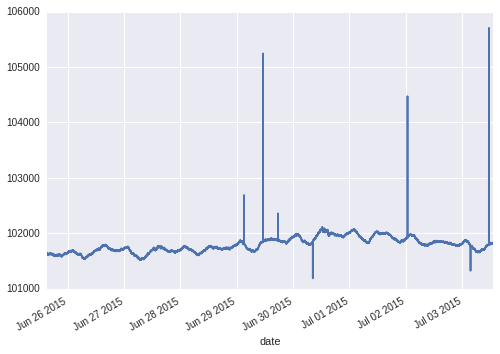

In [193]:
data[~outliers].pressure.plot()

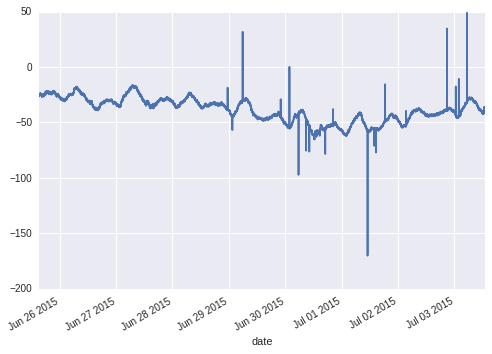

In [194]:
data[~outliers].altitude.plot()

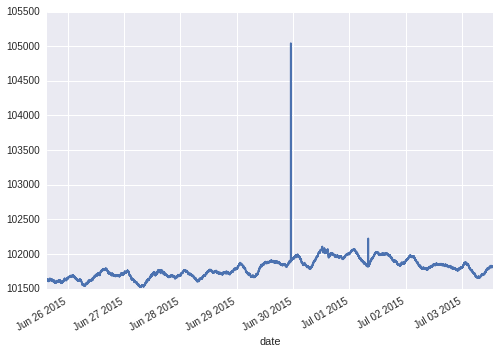

In [204]:
data[~spot_outliers(data)].sealevel_pressure.plot()

In [195]:
data[outliers].head()

,temp,pressure,altitude,sealevel_pressure
date,,,,
2015-06-25 15:07:37.174400,NaN,NaN,NaN,NaN
2015-06-25 15:08:37.290769,NaN,NaN,NaN,NaN
2015-06-25 15:09:37.406928,NaN,NaN,NaN,NaN
2015-06-25 15:10:37.523022,NaN,NaN,NaN,NaN
2015-06-25 15:11:37.638969,NaN,NaN,NaN,NaN


In [66]:
data.head()

,temp,pressure,altitude,sealevel_pressure
date,,,,
2015-06-25 15:07:37.174400,29.3,101637,-25.777027,101637
2015-06-25 15:08:37.290769,29.3,101642,-26.524440,101640
2015-06-25 15:09:37.406928,29.3,101643,-25.943123,101637
2015-06-25 15:10:37.523022,29.3,101644,-25.777027,101637
2015-06-25 15:11:37.638969,29.3,101634,-26.441397,101637


In [196]:
data[outliers].temp.dropna().head(100)

date
2015-06-29 00:30:04.757425    123.4
2015-06-29 02:16:16.421378     58.1
2015-06-29 04:36:31.999731     58.5
2015-06-29 06:55:47.389789     98.3
2015-06-29 07:27:50.925301     67.9
2015-06-29 09:35:04.905765     71.8
2015-06-29 11:27:17.365401     87.6
2015-06-29 13:17:29.549340     94.8
2015-06-29 13:33:31.345615     91.9
2015-06-29 13:49:33.137824     67.4
2015-06-29 14:20:36.557338     85.0
2015-06-29 15:23:43.578008     71.7
2015-06-29 15:39:45.370125    123.3
2015-06-29 17:47:59.445202     92.6
2015-06-30 01:08:17.592235    146.7
2015-06-30 01:23:19.242592     86.1
2015-06-30 02:24:26.038677      5.8
2015-06-30 06:30:53.114578    102.1
2015-06-30 09:49:14.936956     79.6
2015-06-30 14:09:43.894483     64.9
2015-06-30 18:00:09.362701    120.3
2015-06-30 20:59:29.362636     59.9
2015-07-01 02:20:02.628228     86.9
2015-07-01 02:37:04.326589     68.5
2015-07-01 07:12:32.146686    158.2
2015-07-01 08:33:40.475601    -27.1
2015-07-01 09:05:43.746598     86.6
2015-07-01 19:58:50.770

In [197]:
data[outliers]

,temp,pressure,altitude,sealevel_pressure
date,,,,
2015-06-25 15:07:37.174400,NaN,NaN,NaN,NaN
2015-06-25 15:08:37.290769,NaN,NaN,NaN,NaN
2015-06-25 15:09:37.406928,NaN,NaN,NaN,NaN
2015-06-25 15:10:37.523022,NaN,NaN,NaN,NaN
2015-06-25 15:11:37.638969,NaN,NaN,NaN,NaN
2015-06-25 15:12:37.755075,NaN,NaN,NaN,NaN
2015-06-25 15:13:37.817112,NaN,NaN,NaN,NaN
2015-06-25 15:14:37.933191,NaN,NaN,NaN,NaN
2015-06-25 15:15:38.049267,NaN,NaN,NaN,NaN


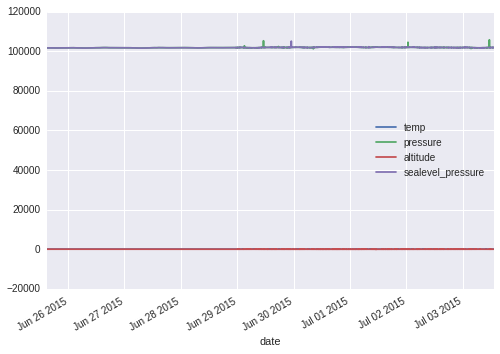

In [198]:
data[~spot_outliers(data)].plot()

In [199]:
data[~mask].describe()

IndexingError: Unalignable boolean Series key provided

/home/jng/.virtualenvs/peakrisk2/lib/python3.4/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


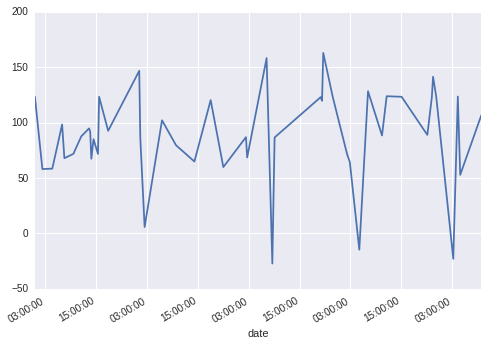

In [200]:
data.temp[spot_outliers(data.temp)].plot()

In [201]:
data.temp[data.temp > 50.0]

date
2015-06-29 00:30:04.757425    123.4
2015-06-29 02:16:16.421378     58.1
2015-06-29 04:36:31.999731     58.5
2015-06-29 06:55:47.389789     98.3
2015-06-29 07:27:50.925301     67.9
2015-06-29 09:35:04.905765     71.8
2015-06-29 11:27:17.365401     87.6
2015-06-29 13:17:29.549340     94.8
2015-06-29 13:33:31.345615     91.9
2015-06-29 13:49:33.137824     67.4
2015-06-29 14:20:36.557338     85.0
2015-06-29 15:23:43.578008     71.7
2015-06-29 15:39:45.370125    123.3
2015-06-29 17:47:59.445202     92.6
2015-06-30 01:08:17.592235    146.7
2015-06-30 01:23:19.242592     86.1
2015-06-30 06:30:53.114578    102.1
2015-06-30 09:49:14.936956     79.6
2015-06-30 14:09:43.894483     64.9
2015-06-30 18:00:09.362701    120.3
2015-06-30 20:59:29.362636     59.9
2015-07-01 02:20:02.628228     86.9
2015-07-01 02:37:04.326589     68.5
2015-07-01 07:12:32.146686    158.2
2015-07-01 09:05:43.746598     86.6
2015-07-01 19:58:50.770681    123.0
2015-07-01 20:17:52.648527    119.6
2015-07-01 20:34:54.370

In [202]:
bad = data.temp[data.temp > 50.0]
bad.describe()

count     42.000000
mean      98.561905
std       29.104638
min       52.900000
25%       71.725000
50%       92.250000
75%      123.150000
max      162.900000
Name: temp, dtype: float64

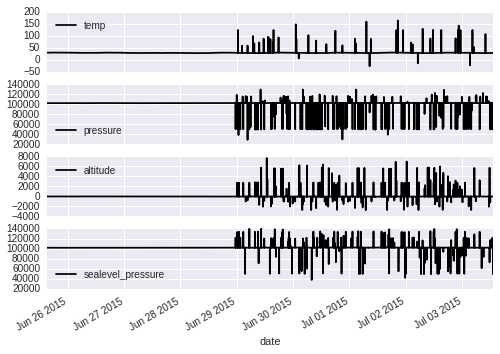

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c716c6b70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0c71896748>], dtype=object)

In [203]:
data.plot(subplots=True)

In [27]:
mask = data.temp < 50.0

mask = mask & (abs(data.altitude) < 100.0)

good = data[mask]

In [28]:
good.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48b798c5f8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b752b588>], dtype=object)

In [29]:
good.describe()

              temp       pressure     altitude  sealevel_pressure
count  5997.000000    5997.000000  5997.000000        5997.000000
mean     28.644489  101682.101884   -31.575287      101680.632816
std       0.759484    1541.214027     7.020223        1280.501740
min      27.200000   37993.000000   -56.873967       49539.000000
25%      28.000000  101642.000000   -35.157337      101643.000000
50%      28.600000  101702.000000   -31.339822      101702.000000
75%      29.400000  101748.000000   -26.441397      101748.000000
max      30.100000  128808.000000    31.768412      121592.000000

In [30]:
data.describe()

              temp       pressure     altitude  sealevel_pressure
count  6033.000000    6033.000000  6033.000000        6033.000000
mean     28.775535  101546.593569   -22.896557      101749.929057
std       2.986311    3129.776450   226.384162        1972.425764
min      27.200000   28421.000000 -2067.737364       49539.000000
25%      28.000000  101642.000000   -35.240311      101643.000000
50%      28.600000  101702.000000   -31.339822      101702.000000
75%      29.400000  101748.000000   -26.358353      101749.000000
max     123.400000  128808.000000  7610.794710      139326.000000

In [31]:
data.count()

temp                 6033
pressure             6033
altitude             6033
sealevel_pressure    6033
dtype: int64

In [32]:
mask.value_counts()

True     5997
False      36
dtype: int64

In [33]:
data.temp[mask == False]

date
2015-06-29 00:15:03.099947     28.7
2015-06-29 00:30:04.757425    123.4
2015-06-29 01:00:07.986653     28.6
2015-06-29 02:16:16.421378     58.1
2015-06-29 02:47:19.895202     28.6
2015-06-29 03:49:26.791876     28.3
2015-06-29 04:36:31.999731     58.5
2015-06-29 05:22:37.055336     27.9
2015-06-29 06:55:47.389789     98.3
2015-06-29 07:27:50.925301     67.9
2015-06-29 07:43:52.672374     27.6
2015-06-29 08:15:56.230414     27.6
2015-06-29 09:03:01.390829     27.6
2015-06-29 09:35:04.905765     71.8
2015-06-29 10:24:10.334328     27.7
2015-06-29 11:11:15.557277     27.9
2015-06-29 11:27:17.365401     87.6
2015-06-29 11:43:19.113136     28.0
2015-06-29 12:46:26.116145     28.5
2015-06-29 13:02:27.905121     28.6
2015-06-29 13:17:29.549340     94.8
2015-06-29 13:33:31.345615     91.9
2015-06-29 13:49:33.137824     67.4
2015-06-29 14:20:36.557338     85.0
2015-06-29 14:36:38.309515     28.9
2015-06-29 14:52:40.113594     29.0
2015-06-29 15:23:43.578008     71.7
2015-06-29 15:39:45.370

In [34]:
good.temp[mask == False]

Series([], Name: temp, dtype: float64)

In [35]:
type(good)

pandas.core.frame.DataFrame

In [44]:
data[data.temp > 50.0]

                             temp  pressure     altitude  sealevel_pressure
date                                                                       
2015-06-29 00:30:04.757425  123.4    101808   -40.134605             101811
2015-06-29 02:16:16.421378   58.1    101850   -43.368556             101838
2015-06-29 04:36:31.999731   58.5     28421  -806.764055             101727
2015-06-29 06:55:47.389789   98.3    101695   -30.343719             101690
2015-06-29 07:27:50.925301   67.9    101666   -29.430540             101675
2015-06-29 09:35:04.905765   71.8    101779 -1707.795743             101782
2015-06-29 11:27:17.365401   87.6    101850   -43.865998             101853
2015-06-29 13:17:29.549340   94.8    101882   -46.104193             101883
2015-06-29 13:33:31.345615   91.9    101880   -45.855528             101880
2015-06-29 13:49:33.137824   67.4    101884   -46.850151             101890
2015-06-29 14:20:36.557338   85.0    101894   -46.684387             101887
2015-06-29 1

In [45]:
data[data.altitude > 0.0]

                            temp  pressure     altitude  sealevel_pressure
date                                                                      
2015-06-29 00:15:03.099947  28.7     49788  2728.365527             133102
2015-06-29 01:00:07.986653  28.6     49695  2714.956421             133319
2015-06-29 02:47:19.895202  28.6     49721  2718.988121             133202
2015-06-29 05:22:37.055336  27.9     49250  2729.020100             139309
2015-06-29 05:53:40.477528  27.8     54037    31.768412             101697
2015-06-29 07:43:52.672374  27.6     49055  2795.798273             133472
2015-06-29 08:15:56.230414  27.6     49039  2758.521361             101702
2015-06-29 09:03:01.390829  27.6     49033  2792.613214             133667
2015-06-29 10:24:10.334328  27.7     49095  5708.784518             139326
2015-06-29 12:46:26.116145  28.5    101870  7610.794710             101862
2015-06-29 13:02:27.905121  28.6    101878  3444.553889             101875
2015-06-29 15:55:47.11346

In [46]:
data[data.pressure > 110000.0]

                            temp  pressure     altitude  sealevel_pressure
date                                                                      
2015-06-29 00:00:01.421409  28.8    118018   -39.056399             101791
2015-06-29 02:31:18.059312  28.6    114827   -42.373601             101837
2015-06-29 03:49:26.791876  28.3    115708 -1022.457395             101762
2015-06-29 04:20:30.231987  28.1    114477   -33.497720             101734
2015-06-29 06:08:42.060109  27.8    114872   -29.430540             101679
2015-06-29 10:08:08.582132  27.6    128808   -40.051670             101813
2015-06-29 18:39:35.176405  29.8    112674   -44.031806             101850
2015-06-29 19:56:43.548595  29.5    115516 -1016.637971             101847
2015-06-29 20:12:45.188962  29.5    115597 -1019.056818             101848
2015-06-29 20:59:50.346986  29.5    114416   -41.710245             101828

In [49]:
data.diff()[:100].temp.plot()